In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

## Building the basic structure

Start with writing the structure for the forest which is an ensemble of trees

In [52]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)] # creates n trees as a list

    # creates a new decision tree from a sample subset of data
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz] 
        # get n rows of data, shuffle them and sample them "sample_sz" at a time. ie shuffle (1,n), then take sample_sz from that 
        # store those in idx as indexes of rows
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], # iloc = integer locations
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        # self.x.iloc[idxs] = data in those shuffled rows
        # self.y[idxs] =  data in those shuffled columns
        # idxs = 0,sample_sz list
        # min_leaf = passed by user or default 5
          
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0) 
        # emsemble predict calls tree predict for each tree
        # self.trees = the tree created in the __init__ function
        
        
        

Next write the class for a single decision tree, which makes the forest

In [51]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        # x = shuffled row of data
        # y = shuffled row of response variable
        # index = 0,sample_sz as a list
        # min_leaf = passed by user or default 5
        
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        # n = number of rows in the shuffled data
        # c = number of columns in the shuffled data (without the response variable)
        
        self.val = np.mean(y[idxs]) 
        # every node in the tree is the avg of the values of the dependent variable in the branch of the tree
        
        self.score = float('inf')
        # some initial score as infinity.
        
        self.find_varsplit()
        
    
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            # send each column to the find_better_split() function, this returns the best row to split on, for that column.
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
        
            
    
    def find_better_split(self, var_idx): 
        # for a column, get the best row to split on.
        # go through every row and and try to minimize the standard deviation

        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs] 
        # self.x.values[self.idxs,var_idx] == take idxs rows (as idxs is an array) and the var_idx column

        # goto each row of data and check for score
        for i in range(1,self.n-1):
            lhs = x<=x[i] # lhs - boolean array of 1 each time its x[i] >= x
            rhs = x>x[i] # rhs - boolean array of 1 each time x > x[i] < x


            if rhs.sum()==0: continue # if everything went to the left split, 
            lhs_std = y[lhs].std()
            rhs_std = y[rhs].std()
            curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum() # current_score = weigthed avg
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,x[i]
                # returning variable name, score, and optimal row


                # n^2 complexity

    @property # decorator
    def split_name(self): 
        return self.x.columns[self.var_idx]
        # returns the column on which split has happened x.columns[var_idx]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs,self.var_idx]
        # returns a list of data value at x[idxs, var_idx]
        # eg. df_raw.values[[1,2,3], 2] = will return 3 values of column 2 at rows 1,2 and 3

    @property
    def is_leaf(self): 
        return self.score == float('inf') 
        # everything that has a split, has a score to split on.
        # this returns whether or not a node is a leaf, by comparing the score woth infinity.
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)
    
    def __repr__(self):
        # how to represent a tree object.
        # __repr__ is  special function that gets called when you try to "print" a tree object.
        
        s = "n: %s; val: %s" % (self.n, self.val)
#         s = 'n: {self.n}; val:{self.val}'
        # n = number of rows in the shuffled data for that row, or for the matter of fact, in the tree.
        # val = mean of the response variable value for that node.
        
        if not self.is_leaf:
            # if the node is not a leaf, print these as well
            
            s += ';score: %s; split: %s; var: %s' % (self.score, self.split, self.split_name)
#           s += '; score:{self.score}; split:{self.split}; var:{self.split_name}'
            # score = score at that point. score is the weighted std_dev of the response variable values
            # split = the row of data that gives the best split.
            # split_name = the variable on which the node is spliting. basically the variable name for that node.
            
        return s

## Run the tree

In [12]:
# load data
# 1. Import the dataset as a pandas dataframe.

data_path = 'data/'
train = pd.read_csv(data_path+'imports-85.data', header=None, na_values=["?"]) #NA's are specified as ? here. So changing that


In [13]:

# 2. Prepare this dataset for running Random Forest. What are the steps you need to do?

# 2a. Rename the columns to logical names. Use data description as reference.
train.columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
                'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
                'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 
                'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
                'highway-mpg', 'price']

# 2b. Fix missing values. Here NA is represented by question marks '?'.
# otherwise we could use the fillna function (eg. train['source_type'].fillna(train['source_type'].mode()[0],inplace=True))

def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col].fillna('no_value', inplace=True)
        else:
            df[col].fillna(0, inplace=True)
    return df
        
train = fill_missing(train) 

# 2c. Convert all "object" to category
def convert_category(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype('category')
    return df
        
train = convert_category(train)

# 2d. Remove the response variable and store it as another list. 
# Here the response variable is price which is the last column.

y = train.price
X = train.drop('price', axis=1)

# 2e. Convert category 

# OPTION 1: one hot encoded
# X = pd.get_dummies(X)

# OPTION 2: convert category to integer
def convert_cat_to_int(df):
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

X = convert_cat_to_int(X)

# 2f. split into train and validation set

train_rows = int(X.shape[0]*0.8)
X_train = X[:train_rows]
y_train = y[:train_rows]

X_valid = X[train_rows:X.shape[0]]
y_valid = y[train_rows:X.shape[0]]



In [157]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        
        # self.x.values[self.idxs,var_idx] == take idxs rows (as idxs is an array) and the var_idx column

        # goto each row of data and check for score
        for i in range(1,self.n-1):
            lhs = x<=x[i] # lhs - boolean array of True each time its x[i] >= x
            rhs = x>x[i] # rhs - boolean array of True each time x > x[i] < x
            
            if rhs.sum()==0: continue # if everything went to the left split, 
            lhs_std = y[lhs].std()
            rhs_std = y[rhs].std()
            curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum() # current_score = weigthed avg
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
            # how to represent a tree object.
            # __repr__ is  special function that gets called when you try to "print" a tree object.

            s = "n: %s; val: %s" % (self.n, self.val)
            # n = number of rows in the shuffled data for that row, or for the matter of fact, in the tree.
            # val = mean of the response variable value for that node.

            if not self.is_leaf:
                # if the node is not a leaf, print these as well

                s += ';score: %s; split: %s; var: %s' % (self.score, self.split, self.split_name)
                # score = score at that point. score is the weighted std_dev of the response variable values
                # split = the row of data that gives the best split.
                # split_name = the variable on which the node is spliting. basically the variable name for that node.

            return s
        
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [160]:
ens = TreeEnsemble(X_train[cols], y_train.as_matrix(), 10, 100)

In [161]:
ens.trees

[n: 100; val: 12292.38;score: 737142.484286; split: 17; var: make,
 n: 100; val: 13093.88;score: 795701.067805; split: 10; var: make,
 n: 100; val: 12698.59;score: 766241.91781; split: 9; var: make,
 n: 100; val: 13293.96;score: 773640.942864; split: -1; var: symboling,
 n: 100; val: 13345.98;score: 825822.239329; split: 17; var: make,
 n: 100; val: 13696.18;score: 840021.517775; split: 17; var: make,
 n: 100; val: 12388.24;score: 802584.438034; split: 15; var: make,
 n: 100; val: 12898.73;score: 758475.099982; split: 17; var: make,
 n: 100; val: 13582.41;score: 841097.461453; split: 15; var: make,
 n: 100; val: 13320.07;score: 841716.280028; split: 17; var: make]

In [162]:
preds = ens.predict(X_valid[cols])
preds

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error


array([ 8195.73333333,  8195.73333333,  8195.73333333])

## Building tree interpretations

Confidence Intervals

In [140]:
from IPython.display import display
from sklearn import metrics



In [141]:
def score_rmse(y_pred, y_true):
    return np.sqrt(metrics.mean_squared_error(y_pred=y_pred, y_true=y_true))

In [142]:
class TreeConfidenceInterpreter():
    def __init__(self, model, x, y):
        self.model = model
        self.x = x
        self.y = y
    
    def tree_confidence(self):
        preds = np.stack([t.predict(np.array(self.x)) for t in self.model.trees])
        mean = np.mean(preds, axis=0)
        std = np.std(preds, axis=0)
        self.mean = mean
        self.std = std
        return list(zip(mean, std))
    
    def worst_rows(self, n):
        # sort the standard deviations from worst to best and return the indexes of the top n standard deviations
        worst_indexes = self.std.argsort()[::-1][:n]
        
        # data at these worst indexes
        worst_rows = self.x.iloc[worst_indexes]
        
        return worst_rows
    
    def feature_importance(self, n):
        # take one feature, shuffle it. 
        # get the rmse of the predicted value - true value
        # highest rmse values are the most important 'n' features
        
        feature_imp = dict()
        for feature in list(self.x):
            x_tmp = self.x.copy()
            x_tmp[feature] = np.random.permutation(x_tmp[feature])
            
            y_new_pred = ens.predict(x_tmp.values)
            score = score_rmse(y_new_pred, self.y)
            
            feature_imp[feature] = score
        return feature_imp

In [163]:
tree_conf = TreeConfidenceInterpreter(ens, X_train, y_train)

In [164]:
tree_conf.tree_confidence()

[(14959.9, 988.07974880573283),
 (14959.9, 988.07974880573283),
 (18204.5, 2662.7961220303741),
 (6531.75, 835.53270183358666),
 (6531.75, 835.53270183358666),
 (15534.5, 730.19586413509626),
 (6554.0, 630.2544459713605),
 (18204.5, 2662.7961220303741),
 (6554.0, 630.2544459713605),
 (11140.541666666668, 8149.0833990573237),
 (6531.75, 835.53270183358666),
 (7855.5047619047618, 142.83629562173189),
 (7855.5047619047618, 142.83629562173189),
 (7855.5047619047618, 142.83629562173189),
 (18204.5, 2662.7961220303741),
 (11140.541666666668, 8149.0833990573237),
 (11140.541666666668, 8149.0833990573237),
 (11140.541666666668, 8149.0833990573237),
 (6531.75, 835.53270183358666),
 (6554.0, 630.2544459713605),
 (7855.5047619047618, 142.83629562173189),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (6554.0, 630.2544459713605),
 (10492.104761904762, 7898.580134231

In [165]:
tree_conf.worst_rows(10)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
71,-1,0.0,9,1,0,0,3,2,0,115.6,...,0,234,5,3.46,3.10,8.3,155.0,4750.0,16,18
113,0,0.0,13,1,0,0,4,2,0,114.2,...,2,120,5,3.46,2.19,8.4,95.0,5000.0,19,24
63,0,0.0,8,0,0,1,3,1,0,98.8,...,2,122,3,3.39,3.39,22.7,64.0,4650.0,36,42
114,0,0.0,13,0,1,0,4,2,0,114.2,...,2,152,3,3.70,3.52,21.0,95.0,4150.0,25,25
49,0,0.0,7,1,0,2,3,2,0,102.0,...,5,326,5,3.54,2.76,11.5,262.0,5000.0,13,17
48,0,0.0,7,1,0,0,3,2,0,113.0,...,3,258,5,3.63,4.17,8.1,176.0,4750.0,15,19
45,0,0.0,6,1,0,0,3,1,0,94.5,...,2,90,1,3.03,3.11,9.6,70.0,5400.0,38,43
43,0,0.0,6,1,0,0,3,2,0,94.3,...,2,111,1,3.31,3.23,8.5,78.0,4800.0,24,29
73,0,0.0,9,1,0,0,3,2,0,120.9,...,0,308,5,3.80,3.35,8.0,184.0,4500.0,14,16
130,0,0.0,16,1,0,0,4,1,0,96.1,...,2,132,5,3.46,3.90,8.7,0.0,0.0,23,31


In [166]:
feat_imp = tree_conf.feature_importance(10)

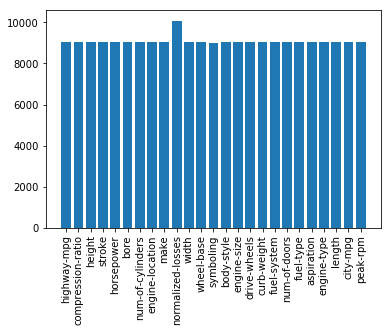

In [167]:
import matplotlib.pylab as plt

plt.bar(range(len(feat_imp)), feat_imp.values(), align='center')
plt.xticks(range(len(feat_imp)), feat_imp.keys(), rotation=90)

plt.show()

Tree Interpretor

gives you prediction, bias and confidence

In [148]:
def tree_interpretor(model, X_row):
    # this is for only 1 row of data
    
    # return a triple of [prediction, bias and feature_contributions],  
    # such that prediction ≈ bias + feature_contributions.
    
    # prediction at each level = bias + score of the feature at that level.
    
    biases = []
    contributions = []
    predictions = []
    
    for t in model.trees:

        # bias is the mean given by the topmost split
        _bias = t.val # value at first split
        biases.append(_bias)
        
        old_node_val = _bias # to take old_node_value across the tree
        
        _temp_contribution = {} # dict to store score at each node
        while not t.is_leaf:
            
            # for each split node in the tree, get the contribution
            feature = t.split_name
       
            t = t.lhs if X_row[feature] <= t.split else t.rhs # which branch to consider next
        
            # new_node_val is the response at the new node of the tree
            new_node_val = t.val
            
            # feature_contribution = value at this level - value at prev level
            _temp_contribution[feature] = new_node_val - old_node_val
            
            # update the value for next iteration
            old_node_val = new_node_val
            
        # when the loop gets over, we were just above the leaf node.
        # t.lhs or t.rhs -> leaf node. 
        # thus new_node_value -> prediction
        predictions.append(new_node_val) 
        
        contributions.append(_temp_contribution)
        
    return [predictions, biases, contributions]

In [168]:
prediction, bias, contributions = tree_interpretor(ens, ens.x.loc[1])

In [169]:
contributions

[{'make': 6832.2391304347821, 'symboling': -2822.0},
 {'make': -4811.726190476189, 'symboling': 242.14285714285688},
 {'make': -971.25, 'symboling': -1406.25},
 {'make': 1801.25, 'symboling': 6478.2132867132877},
 {'make': -4689.1071428571413, 'symboling': -2783.75},
 {'make': 146.0, 'symboling': 5454.4971428571407},
 {'make': 7000.7658730158746, 'symboling': -1101.0},
 {'make': 1236.6666666666661, 'symboling': 6779.2521645021625},
 {'make': 5442.2916666666661, 'symboling': -331.5},
 {'make': -1658.75}]

Feature importance = Contribution from each row of the tree interpretor 

In [171]:
from collections import defaultdict

def feature_importance_tree(contributions):
    
    feature_importance = defaultdict(int)
    for contribution in contributions:
        for (k,v) in contribution.items():
            feature_importance[k] += v
            
    return (feature_importance)

In [172]:
feature_importance  = feature_importance_tree(contributions)

In [173]:
feature_importance

defaultdict(int, {'make': 10328.380003450658, 'symboling': 10509.605451215448})

In [174]:
feat_imp

{'aspiration': 9049.3174169083268,
 'body-style': 9049.3174169083268,
 'bore': 9049.3174169083268,
 'city-mpg': 9049.3174169083268,
 'compression-ratio': 9049.3174169083268,
 'curb-weight': 9049.3174169083268,
 'drive-wheels': 9049.3174169083268,
 'engine-location': 9049.3174169083268,
 'engine-size': 9049.3174169083268,
 'engine-type': 9049.3174169083268,
 'fuel-system': 9049.3174169083268,
 'fuel-type': 9049.3174169083268,
 'height': 9049.3174169083268,
 'highway-mpg': 9049.3174169083268,
 'horsepower': 9049.3174169083268,
 'length': 9049.3174169083268,
 'make': 9049.1082057910207,
 'normalized-losses': 10080.135149712514,
 'num-of-cylinders': 9049.3174169083268,
 'num-of-doors': 9049.3174169083268,
 'peak-rpm': 9049.3174169083268,
 'stroke': 9049.3174169083268,
 'symboling': 8977.2072142867546,
 'wheel-base': 9049.3174169083268,
 'width': 9049.3174169083268}